In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# load dataset
imsize = 224
image_dir = '../train/'
metadata = pd.read_csv('../train.csv')
metadata['filename'] = metadata['id'].apply(lambda x: f"{image_dir}{x}.jpg")
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42)
val_df['stable_height'] = val_df['stable_height'] - 1

In [2]:
import torch
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, is_train=True):
        self.dataframe = dataframe
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filename']
        label = self.dataframe.iloc[idx]['stable_height']
        image = Image.open(img_path).convert('RGB')  # Load the image file
        
        # Resize the image manually
        image = image.resize((224, 224))
        
        # Convert to numpy array and change the range to [-1, 1]
        image = np.array(image, dtype=np.float32)
        image = (image - 127.5) / 127.5  # Normalize the image
        
        # Convert the numpy array to a PyTorch tensor
        image = torch.from_numpy(image).permute(2, 0, 1)  # Change HWC to CHW format for PyTorch
        
        return image, label  # Adjust the label indexing if needed


In [3]:
val_dataset = CustomDataset(val_df, is_train=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification

class CustomViTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomViTModel, self).__init__()
        # Load the pre-trained Vision Transformer and extract the backbone
        self.vit_backbone = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        ).vit
        
        # Add custom fully connected layers
        # Add custom fully connected layers
        self.custom_classifier = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Linear(1024, num_labels)
        )
    
    def forward(self, x):
        # Forward pass through the Vision Transformer backbone
        vit_outputs = self.vit_backbone(x)
        # Extract the last hidden state (we use the CLS token embedding as the feature)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        # Forward pass through the custom classifier
        output = self.custom_classifier(vit_features)
        return output

/home/henrik/anaconda3/envs/CV-tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
loss_fn = nn.CrossEntropyLoss()

In [7]:
device = 'cuda'
# Initialize the custom model with the correct number of labels
model = CustomViTModel(num_labels=6)

# Load the fine-tuned model weights
model.load_state_dict(torch.load('../model/visionT.pth', map_location=device))
model.to(device)

# Placeholder for predictions and true labels
predictions = []
true_labels = []
total_loss = 0.0
total_correct = 0
total_samples = 0
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass to get outputs
        outputs = model(inputs)  # Directly get the output tensor
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * inputs.size(0)  # Multiply by batch size
        # Get the predicted class
        _, predicted_labels = torch.max(outputs, 1)
        correct = (predicted_labels == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        # Store predictions and true labels
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_540310/1931020207.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`.

In [8]:
# Compute the average loss and accuracy
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f'Validation Loss: {average_loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Loss: 1.1662
Validation Accuracy: 0.5247


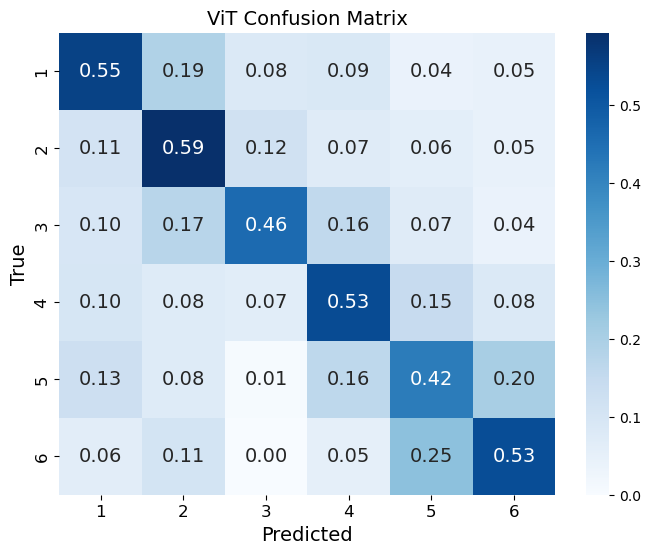

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5, 6], yticklabels=[1, 2, 3, 4, 5, 6], annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('ViT Confusion Matrix', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
